# Lista 4
Arthur Pontes de Miranda Ramos Soares

In [2]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Funções Auxiliares

In [132]:
def show_images(
    *images: np.ndarray, titles: list[str] | None = None, columns: int = 2, scale: int = 5
) -> None:
    num_images = len(images)

    if titles is None:
        titles = [f'Image {i + 1}' for i in range(num_images)]

    rows = (num_images + columns - 1) // columns

    fig, axes = plt.subplots(rows, columns, figsize=(scale * columns, scale * rows))
    axes = np.array(axes).reshape(rows, columns)

    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)

    for i in range(num_images, rows * columns):
        fig.delaxes(axes.flat[i])

    plt.tight_layout()


def show_image(image: np.ndarray, title: str = None, dpi: int = 100) -> None:
    height, width, _ = image.shape

    figsize = (width / dpi, height / dpi)

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title if title else '')

    plt.tight_layout()


def contar_ocorrencias(arr: np.ndarray) -> dict:
    valores, contagens = np.unique(arr, return_counts=True)
    return dict(zip(valores.tolist(), contagens.tolist()))

## Questão 1

O mapa de disparidade obtido por meio da metodologia descrita no tutorial atribui valores diferentes para objetos em profundidades distintas, sendo valores mais altos referentes a objetos/regiões mais perto da câmera. Como queremos apenas os objetos mais próximos, foi criada uma máscara aplicado um threshold no mapa de disparidade, cujo valor varia de acordo com a imagem. A máscara é obtida selecionado os valores menores que o threshold, ou seja, indica o background. 

Para obter a imagem final, foi aplicado um GaussianBlur na imagem da esquerda e depois foi usada a função `bitwise_and` para aplicar a máscara, o que basicamente remove a região que estamos considerando como foreground da imagem borrada. Para obter a parte da imagem sem borrar, o inverso da máscara foi aplicado na imagem da esquerda. No final, as duas foram combinadas.

Como o algoritmo StereoBM é muito sensível à natureza da foto, foram utilizadas imagens obtidas em https://cecas.clemson.edu/~stb/research/stereo_p2p/, já perfeitamente ajustadas para esse tipo de processamento.

In [ ]:
def blur_background(filenames, nDisp, bSize, threshold):
    imgL = cv.imread(filenames[0], cv.IMREAD_GRAYSCALE)
    imgR = cv.imread(filenames[1], cv.IMREAD_GRAYSCALE)

    stereo = cv.StereoBM_create(numDisparities=nDisp, blockSize=bSize)
    disparity = stereo.compute(imgL, imgR)
    disparity = cv.medianBlur(disparity, 5)

    mask = disparity < threshold
    mask = mask.astype(np.uint8) * 255

    img = cv.imread(filenames[0], cv.IMREAD_GRAYSCALE)

    background = cv.GaussianBlur(img, (25, 25), 0)
    foreground = cv.bitwise_and(img, img, mask=~mask)
    background = cv.bitwise_and(background, background, mask=mask)
    output = foreground + background

    images = [imgL, disparity, background, foreground, output]
    titles = ['Original', 'Disparity', 'Background', 'Foreground', 'Final']
    show_images(*images, titles=titles, columns=5)

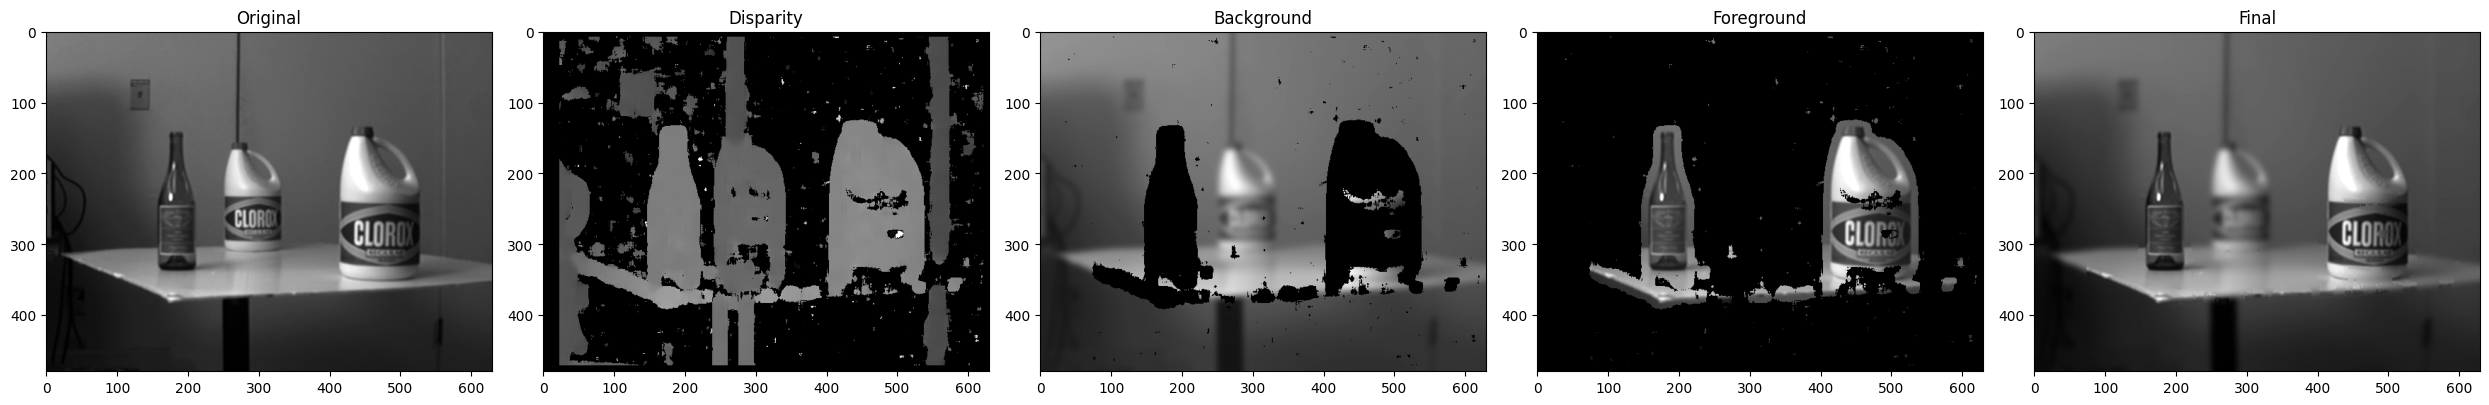

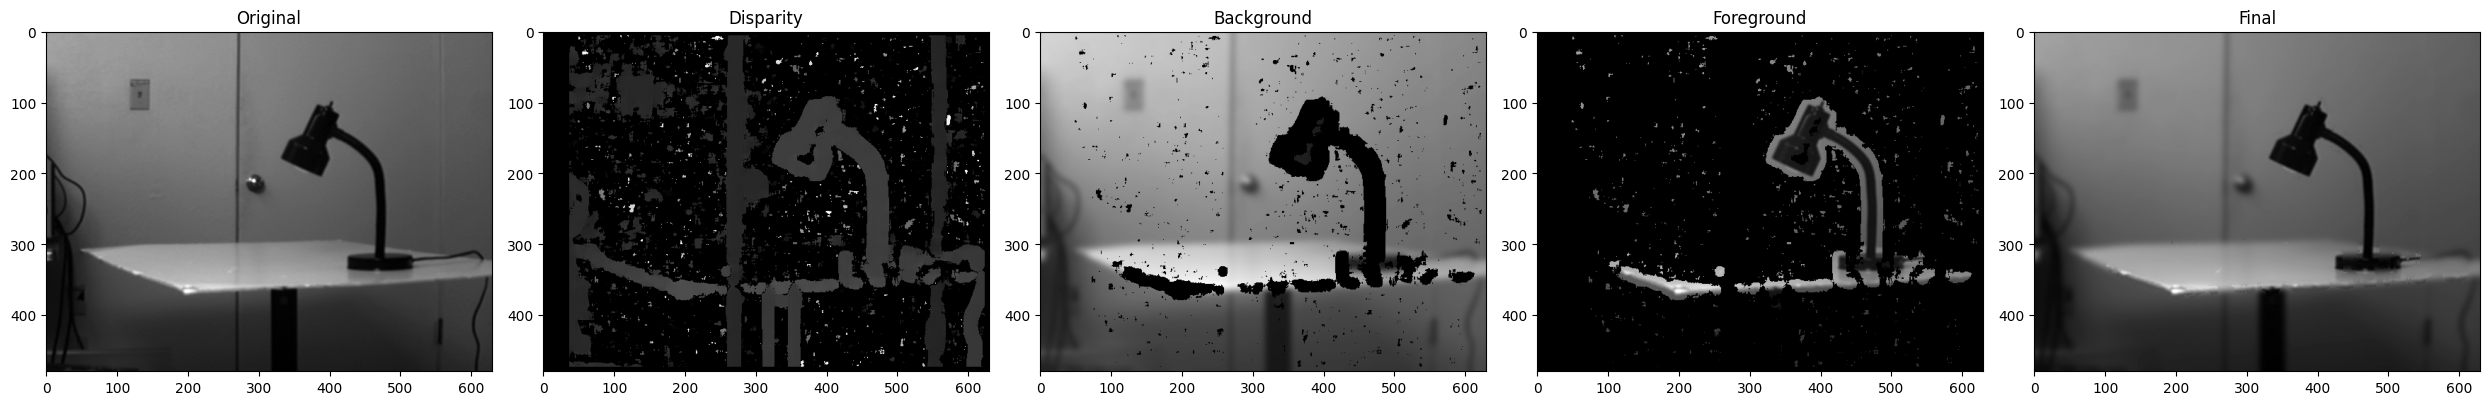

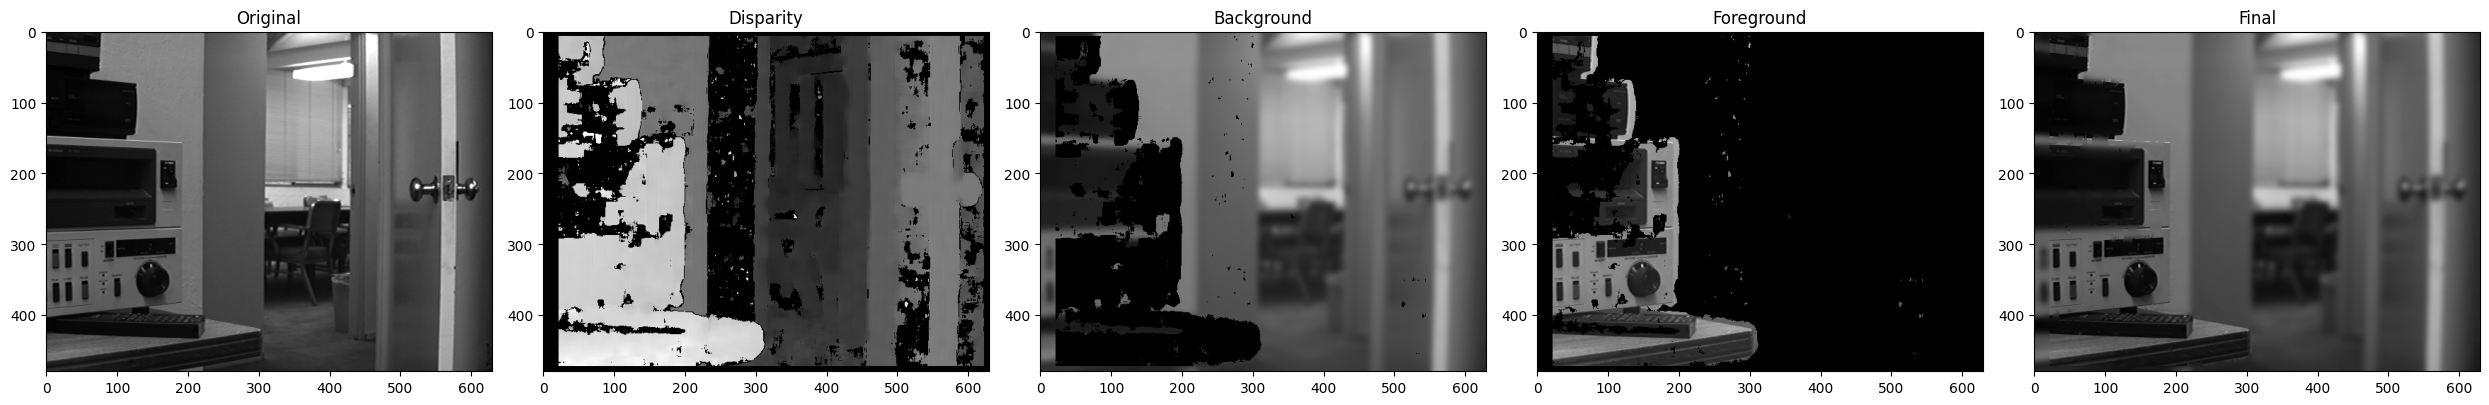

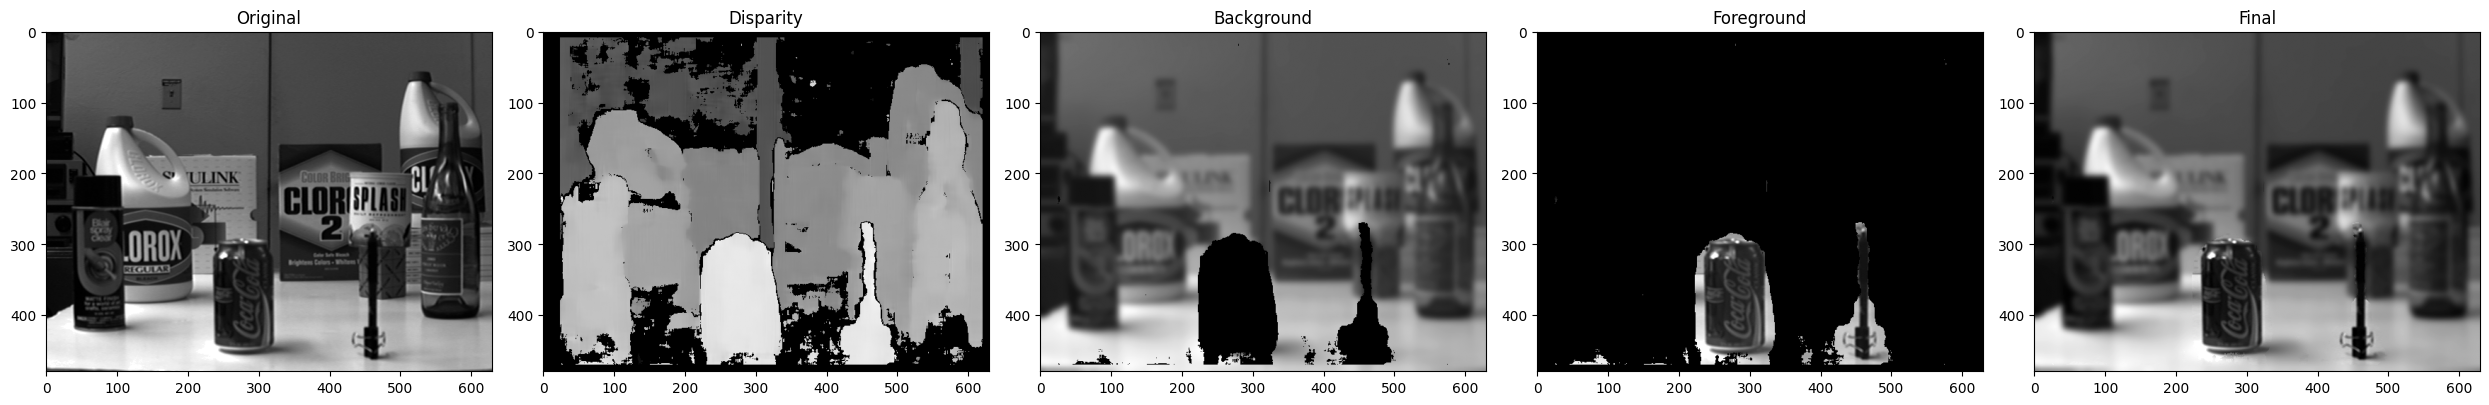

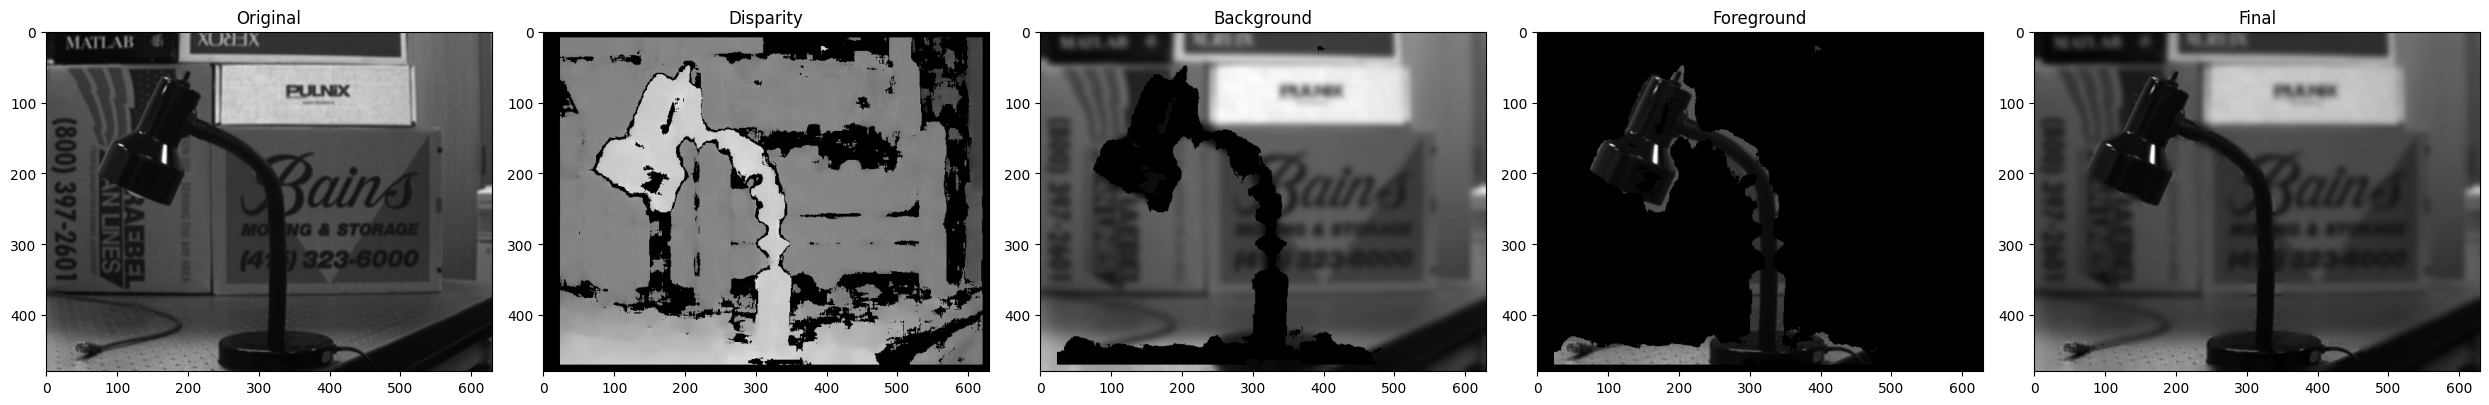

In [92]:
blur_background(['./assets/a1.png', './assets/a2.png'], 16, 17, 105)
blur_background(['./assets/b1.png', './assets/b2.png'], 32, 13, 105)
blur_background(['./assets/c1.png', './assets/c2.png'], 16, 15, 120)
blur_background(['./assets/f1.png', './assets/f2.png'], 16, 19, 200)
blur_background(['./assets/tl1.png', './assets/tl2.png'], 16, 19, 170)

Depois de tentar com as imagens acima, tentei tirar fotos eu mesmo com o celular. Os resultados foram absolutamente horríveis. Depois tentei com uma câmera dslr montada num tripé. Os resultados foram ruins, como pode ver abaixo. Foi necessário inclusive modificar a função, pois os valores do mapa de disparidade estavam estranhos. 

Acredito que o problema tenha sido a qualidade das imagens que eu consegui tirar. Pelo que eu li, as imagens tem que passar por um processo de retificação para garantir que estão no mesmo plano e haver correspondência correta. Também tem o fato de os objetos que eu usei e o fundo não estarem numa distância tão boa, questões de iluminação e textura dos objetos. Infelizmente não tinha disponível um espaço muito adequado para obter fotos que atendenssem a todos esses critérios.

In [106]:
def blur_background_2(filenames, nDisp, bSize, threshold, factor=2):
    imgL = cv.imread(filenames[0], cv.IMREAD_GRAYSCALE)
    imgR = cv.imread(filenames[1], cv.IMREAD_GRAYSCALE)

    # Adicionei essa etapa de redução da imagem (resolução grande não estava funcionando)
    if factor > 0:
        imgL = cv.resize(imgL, (int(imgL.shape[1] / factor), int(imgL.shape[0] / factor)))
        imgR = cv.resize(imgR, (int(imgR.shape[1] / factor), int(imgR.shape[0] / factor)))

    stereo = cv.StereoBM_create(numDisparities=nDisp, blockSize=bSize)
    disparity = stereo.compute(imgL, imgR)
    disparity = cv.medianBlur(disparity, 5)

    mask = disparity < threshold
    mask = mask.astype(np.uint8) * 255

    img = imgL

    # Tive que inverter a lógica da máscara. Por algum motivo as imagens tiradas
    # por mim obtinham valores diferentes das imagens de exemplo.
    background = cv.GaussianBlur(img, (25, 25), 0)
    foreground = cv.bitwise_and(img, img, mask=mask)
    background = cv.bitwise_and(background, background, mask=~mask)
    output = foreground + background

    images = [imgL, disparity, background, foreground, output]
    titles = ['Original', 'Disparity', 'Background', 'Foreground', 'Final']
    show_images(*images, titles=titles, columns=5)

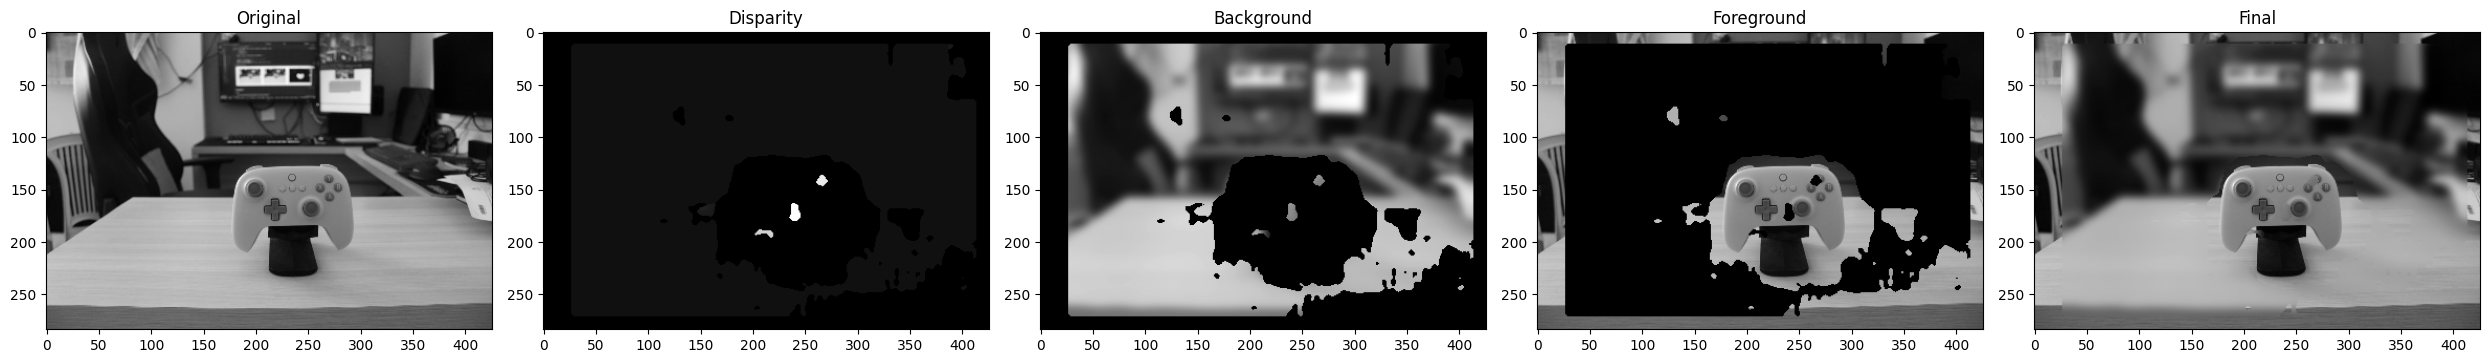

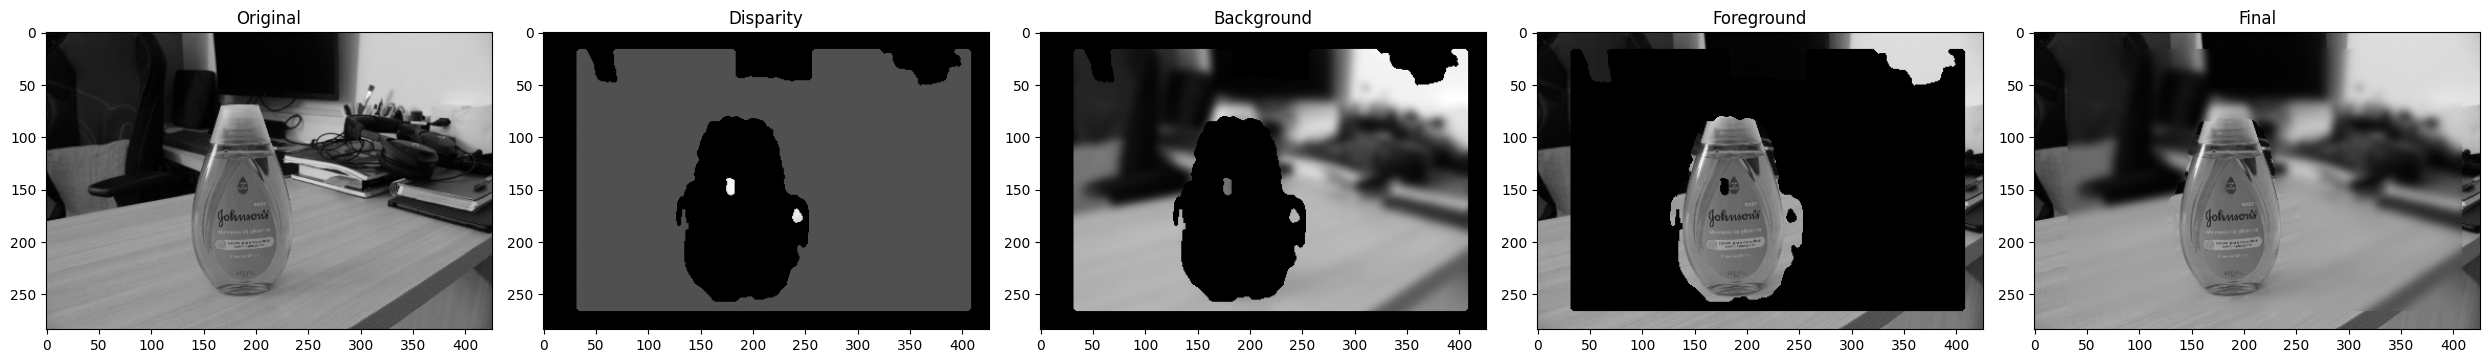

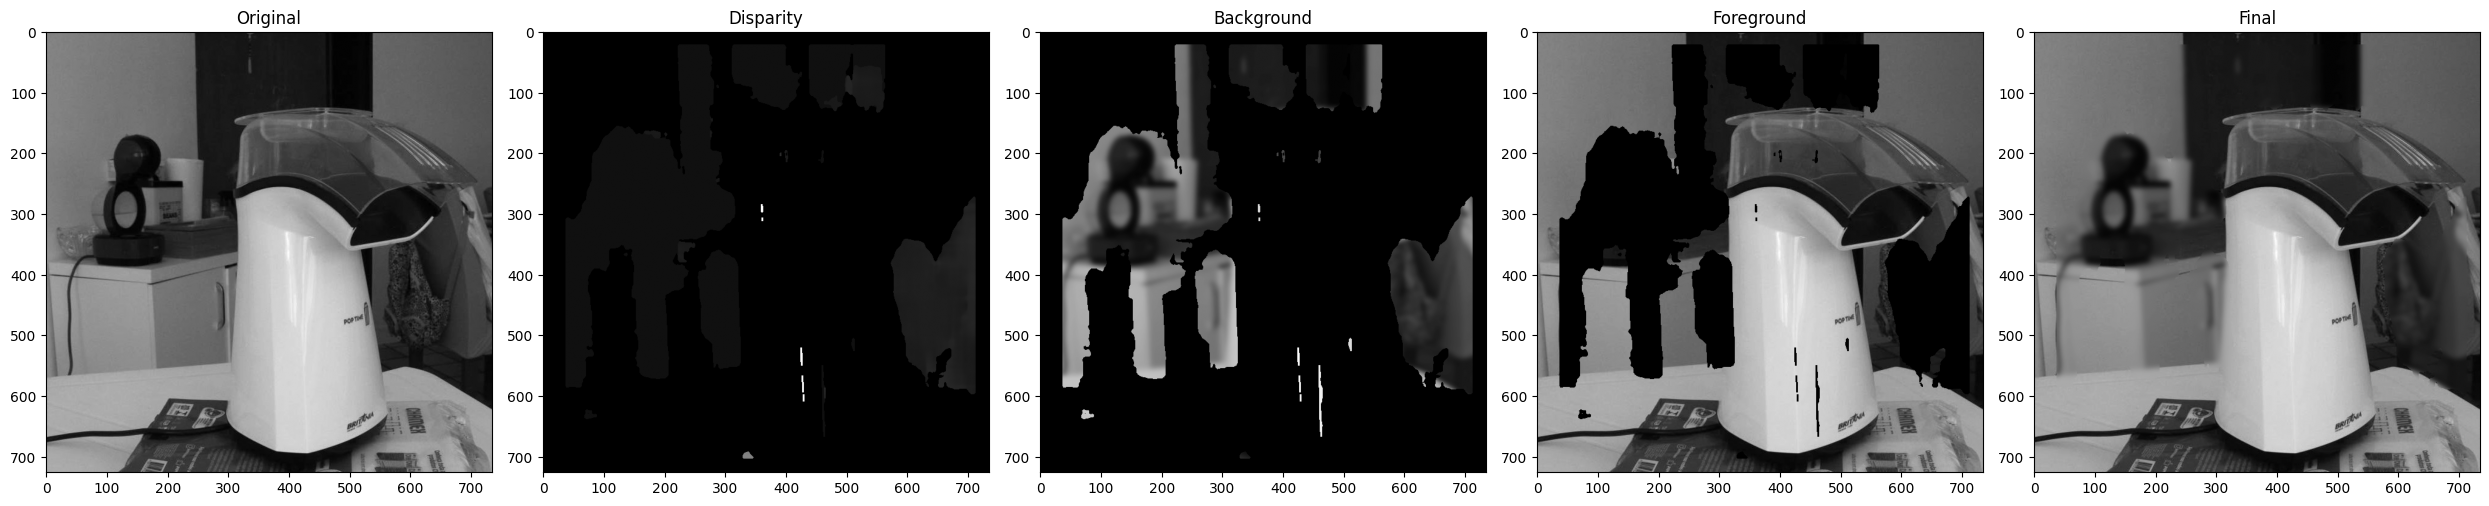

In [ ]:
blur_background_2(['./assets/controller-left.jpg', './assets/controller-right.jpg'], 16, 25, 0, 3)
blur_background_2(['./assets/shampoo-left.jpg', './assets/shampoo-right.jpg'], 16, 35, 0, 3)
blur_background_2(['./assets/pipoca-left.jpg', './assets/pipoca-right.jpg'], 16, 45, 0, 1)

## Questão 2

### Letra a
Nessa questão, foram usadas imagens do banco de imagens citado no tutorial, KITTI Road Detection Evaluation 2013 (https://www.cvlibs.net/datasets/kitti/eval_road.php). O Dataser apresenta vários pares de imagens de várias ruas, assim como as informações de calibração de câmera.

Abaixo são apresentados os resultados para 3 pares de imagens do KITTI. Além do código apresentado no tutorial, foi necessário inverter a imagen no eixo X e também filtrar alguns valores, de forma a obter uma imagem um pouco mais limpa. Apesar disso, ainda nota-se ruído. Carregando os arquivos .ply no MeshLab, é possível ver (em alguns ângulos específicos) o caminho das ruas. Nos prints do MeshLab fica um pouco dífícil de perceber a profundidade, mas é possível notar que se a nuvem de pontos está associada com a imagem usada em cada caso por meio da curvatura da rua que aparece na nuvem de pontos.


In [210]:
ply_header = """ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
"""


def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')


def read_calibration_file(filepath):
    calib_data = {}

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            key, *values = line.strip().split()
            key = key.rstrip(':')
            values = np.array([float(v) for v in values])

            if key.startswith('P'):
                calib_data[key] = values.reshape(3, 4)
            elif key == 'R0_rect':
                calib_data[key] = values.reshape(3, 3)
            else:
                calib_data[key] = values.reshape(3, 4)

    return calib_data

In [211]:
def reconstruction_3d(filename: str, nDisp: int, bSize: int, dim_filter: float = 25.0):
    imgL = cv.imread(f'./assets/{filename}-left.png')
    imgR = cv.imread(f'./assets/{filename}-right.png')
    imgL_gray = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    imgR_gray = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    stereo = cv.StereoBM_create(numDisparities=nDisp, blockSize=bSize)
    disparity = stereo.compute(imgL_gray, imgR_gray).astype(np.float32) / 16.0

    calib = read_calibration_file(f'./assets/{filename}.txt')

    cam1 = calib['P2'][:, :3]
    cam2 = calib['P3'][:, :3]

    Q = np.zeros((4, 4))

    cv.stereoRectify(
        cameraMatrix1=cam1,
        cameraMatrix2=cam2,
        distCoeffs1=0,
        distCoeffs2=0,
        imageSize=imgL.shape[:2],
        R=np.identity(3),
        T=np.array([0.54, 0.0, 0.0]),
        R1=None,
        R2=None,
        P1=None,
        P2=None,
        Q=Q,
    )

    points = cv.reprojectImageTo3D(disparity, Q)
    colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)

    # Refletir no eixo X
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points, reflect_matrix)

    # Filtrar valor mínimo de disparidade
    mask = disparity > disparity.min()
    out_points = points[mask]
    out_colors = colors[mask]

    # Filtrar valores longe do centro no eixo x
    idx = np.fabs(out_points[:, 0]) < dim_filter
    out_points = out_points[idx]
    out_colors = out_colors[idx]

    # Filtrar valores não finitos
    finite_mask = np.isfinite(out_points).all(axis=1)
    out_points = out_points[finite_mask]
    out_colors = out_colors[finite_mask]

    colors = colors.reshape(-1, 3)
    write_ply(f'out_{filename}.ply', out_points, out_colors)
    return disparity

/tmp/ipykernel_58014/2448444504.py:38: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflect_matrix)


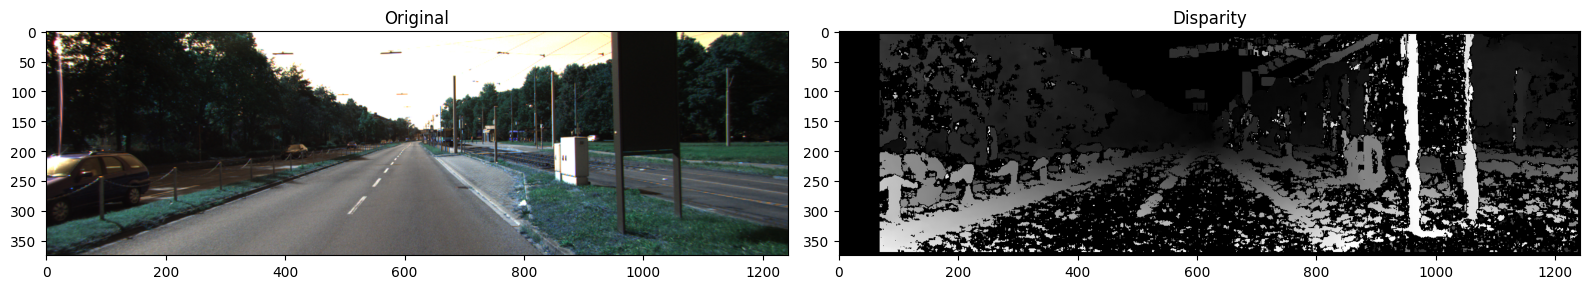

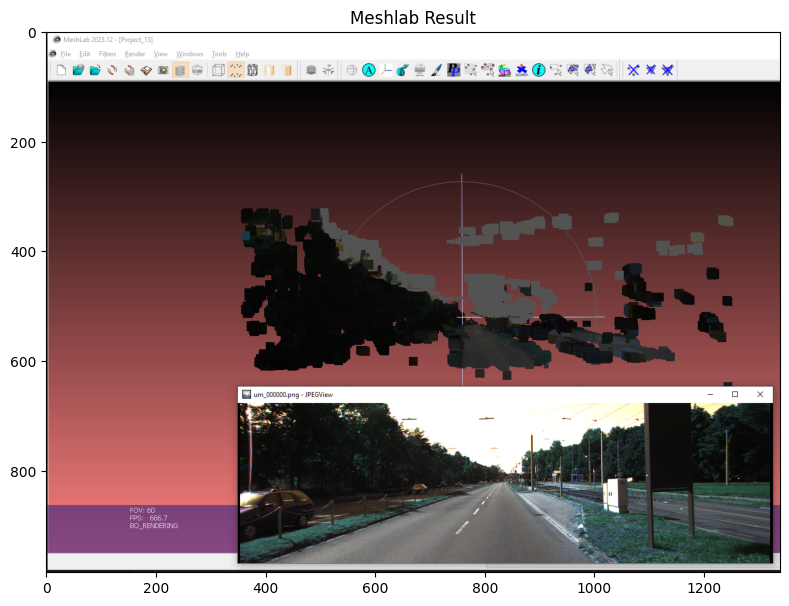

In [140]:
filename = 'road-1'
disp_img = reconstruction_3d(filename, 64, 11, 25.0)
img = cv.imread(f'./assets/{filename}-left.png')
result_print = cv.imread('./assets/result-meshlab-road-1.png', cv.COLOR_BGR2RGB)
show_images(img, disp_img, titles=['Original', 'Disparity'], columns=2, scale=8)
show_images(result_print, titles=['Meshlab Result'], columns=1, scale=8)


/tmp/ipykernel_58014/624659029.py:38: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflect_matrix)


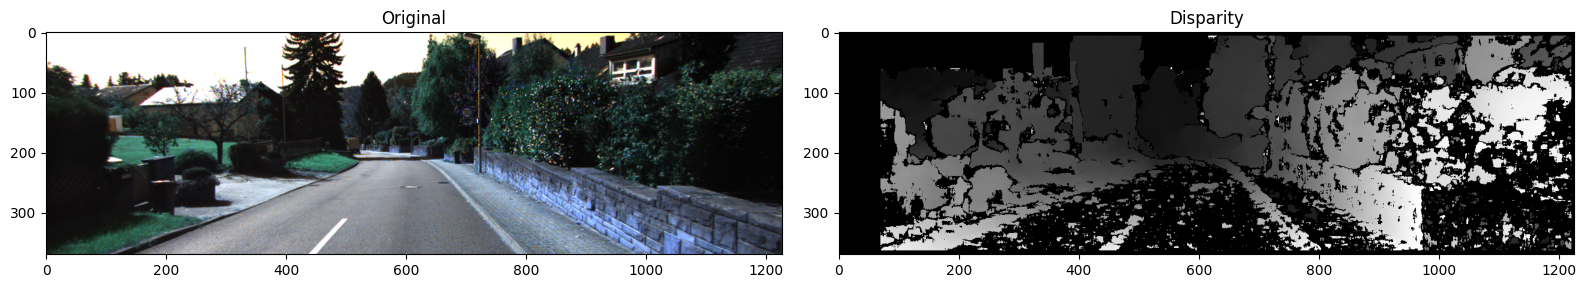

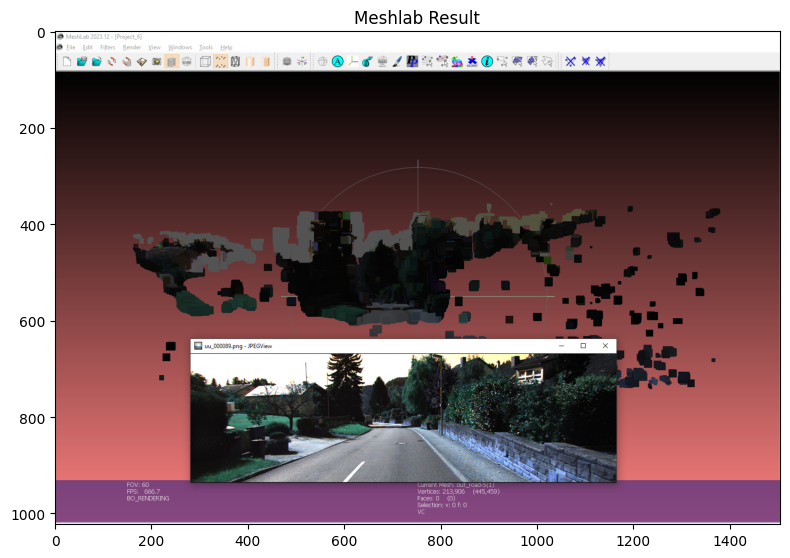

In [205]:
filename = 'road-5'
disp_img = reconstruction_3d(filename, 64, 13, 100.0)
img = cv.imread(f'./assets/{filename}-left.png')
result_print = cv.imread('./assets/result-meshlab-road-5.png', cv.COLOR_BGR2RGB)
show_images(img, disp_img, titles=['Original', 'Disparity'], columns=2, scale=8)
show_images(result_print, titles=['Meshlab Result'], columns=1, scale=8)

/tmp/ipykernel_58014/624659029.py:38: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflect_matrix)


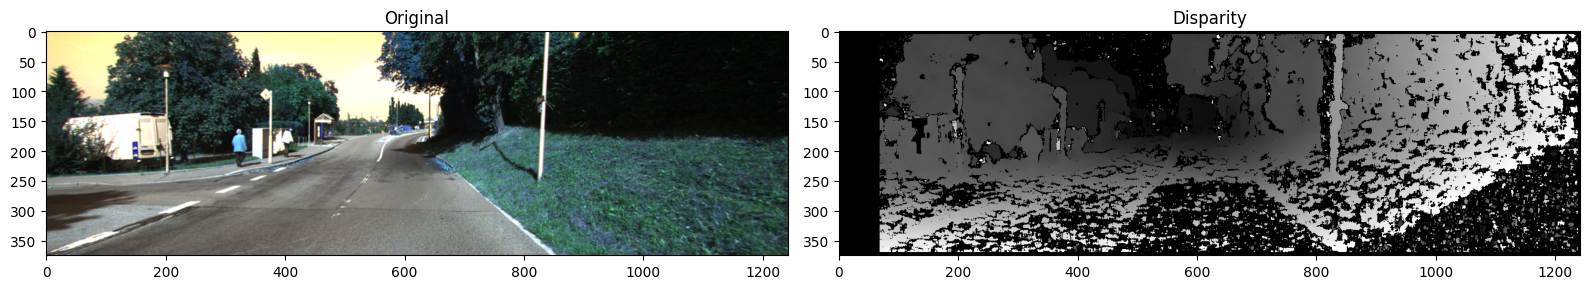

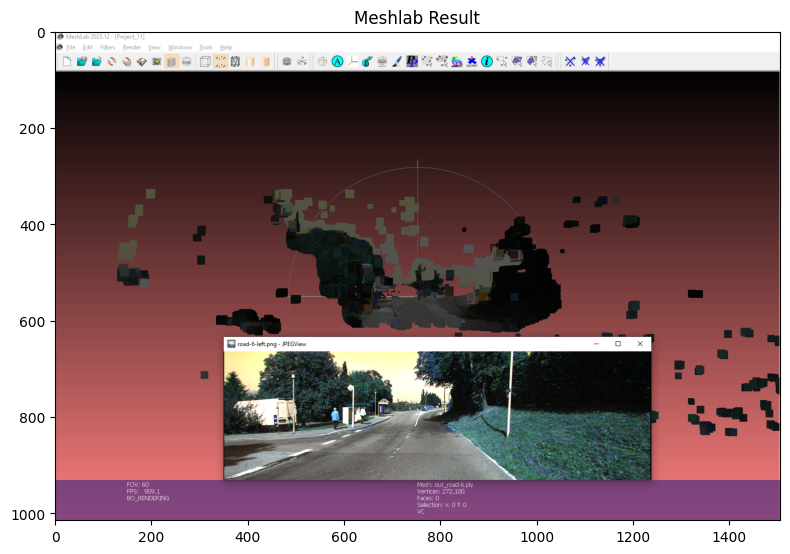

In [209]:
filename = 'road-6'
disp_img = reconstruction_3d(filename, 64, 11, 30.0)
img = cv.imread(f'./assets/{filename}-left.png')
result_print = cv.imread('./assets/result-meshlab-road-6.png')
show_images(img, disp_img, titles=['Original', 'Disparity'], columns=2, scale=8)
show_images(result_print, titles=['Meshlab Result'], columns=1, scale=8)

## Letra b
Inicialmente, o par de imagens é carregado e convertidos para tons de cinza (remover uma dimensão). Depois, é calculada a correspondência stereo entre as duas imagens, gerando o mapa de disparidade, que atribui valores mais altos à objetos e regiões mais próximas da câmera, com base na diferença de posição de um objeto ou região nas duas imagens.

O próximo passo é obter a matriz de reprojeção Q, a partir das informações de calibração fornecidas pelo próprio dataset KITTI. Essa matriz permite converter pontos da imagem 2D, no formato (x, y, disparity), para coordenadas (X, Y, Z) em 3D, reconstruindo a profundidade dos objetos observados na cena. Ou seja, ela combina as informações de uma das imagens com as informações de profundidade geradas pelo mapa de disparidade, retornando uma nuvem de pontos.

Com os pontos 3D gerados, as cores dos pixels correspondentes na imagem original são associadas a cada ponto. Esses dados são então combinados e exportados para um arquivo .ply, que pode ser visualizado em ferramentas como o MeshLab.

No entanto, devido à forma como os dados são processados, a nuvem de pontos pode sair invertida no eixo X. Por isso, uma etapa adicional de correção é aplicada para refletir os pontos antes da exportação. Além disso, filtros podem ser utilizados para remover pontos com coordenadas inválidas (como infinitos ou NaNs) e também para eliminar regiões muito distantes lateralmente, reduzindo ruído na nuvem final.

## Questão 3 

Datasets
- https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
- https://www.kaggle.com/datasets/kipshidze/apple-vs-orange-binary-classification

### Letra a - Extrair features com HoG e Classificar com SVM
O processo de extração de features usando HoG envolveu iterar no dataset e processar cada uma das imagens de forma independente, salvando apenas o vetor de features, a classe (label) e o caminho para a imagem.

Como o dataset utilizado possui imagens de tamanhos diferentes, foi realizado um passo de transformação das imagens para o tamanho 128x128.

Quanto ao HoG, foram testadas diferentes combinações de valores para o **Tamanho da Janela**, **Tamanho do Bloco** e **Tamanho da célula**. No fim, escolhi:
- Janela: 64x64 píxels
- Bloco: 32x32 píxels
- Célula: 16x16 píxels

Ou seja, cada bloco tem 4 células e cada janela tem 4 blocos. O tamanho maior da célula leva o algoritmo a ter um pouco mais de contexto. O tamanho da janela poderia ser maior, mas devido ao tamanho da imagem, mantive em 64x64 píxels. O número de bins ficou no padrão, 9.

Quando ao SVM, foram testadas algumas combinações de parâmetros usando `GridSearchCV`. Os valores `{kernel='rbf', gamma='scale', C=1}` se mostraram adequados para o dataset em questão, então foram utilizados. O código abaixo foi utilizado para isso.
```python
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.001], 'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
```

In [147]:
def extract_features(hog: cv.HOGDescriptor, root: Path) -> pd.DataFrame:
    data = []
    for label, folder in enumerate(root.iterdir()):
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            img_path = folder / fname
            img = cv.imread(img_path, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (128, 128))
            data.append({'features': hog.compute(img), 'label': label, 'path': img_path})
    return pd.DataFrame(data)


def train_svm(features: pd.DataFrame) -> tuple:
    df_train, df_test = train_test_split(
        features, test_size=0.3, stratify=features['label'], random_state=42
    )

    X_train = np.stack(df_train['features'].to_numpy())
    y_train = df_train['label'].to_numpy()

    X_test = np.stack(df_test['features'].to_numpy())

    clf = SVC(kernel='rbf', gamma='scale', C=1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    return y_pred, df_test


def show_examples(df: pd.DataFrame, labels: list, title: str):
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(df.iterrows()):
        img = cv.imread(row['path'])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.subplot(1, len(df), i + 1)
        plt.title(f'Pred: {labels[row["pred"]]}')
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


def generate_cm(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()


hog = cv.HOGDescriptor(
    _winSize=(64, 64),
    _blockSize=(32, 32),
    _blockStride=(16, 16),
    _cellSize=(16, 16),
    _nbins=9,
)

In [148]:
labels = ['Moto', 'Carro']
features: pd.DataFrame = extract_features(hog, Path('./dataset1'))
y_pred, df_test = train_svm(features)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       600
           1       0.95      0.95      0.95       600

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



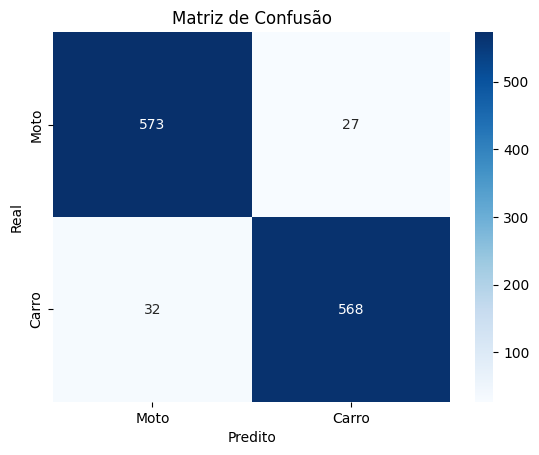

In [149]:
# Acurácia e Matriz de Confusão
result = classification_report(df_test['label'], y_pred)
print(result)

generate_cm(df_test['label'], y_pred, labels)

Com base nos resultados, foi possível concluir que o método clássico que combina extração de features HoG e classificação SVM foi capaz de gerar um modelo bem sucedido em diferenciar carros e motos, dado o dataset utilizado (https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset). O modelo mostrou uma acurácia de 95%, o que é decorrência da baixa taxa de classificações erradas, como é possível ver na matriz de confusão.

Acredito que esse bom resultado esteja ligado também à natureza das classes avaliadas e ao tamanho do Dataset (2000 imagens para cada classe). Anteriormente, testei a metodologia com o outro dataset mencionado acima (laranjas e maças) e o resultado foi consideravelmente pior, provavelmente por conta do tamanho menor do dataset (400 imagens de cada classe) e da natureza mais difícil da diferenciação entre uma laranja e maça (se comparado com diferenciar um carro e uma moto).

Abaixo foram mostrados 5 exemplos em que o modelo classificou corretamente e 5 em que ele classificou de forma errada.

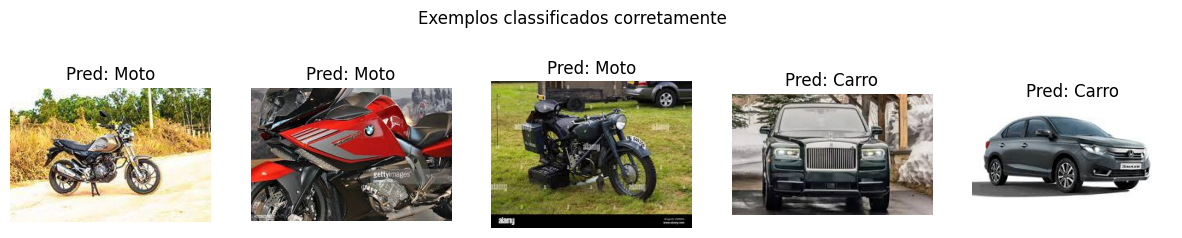

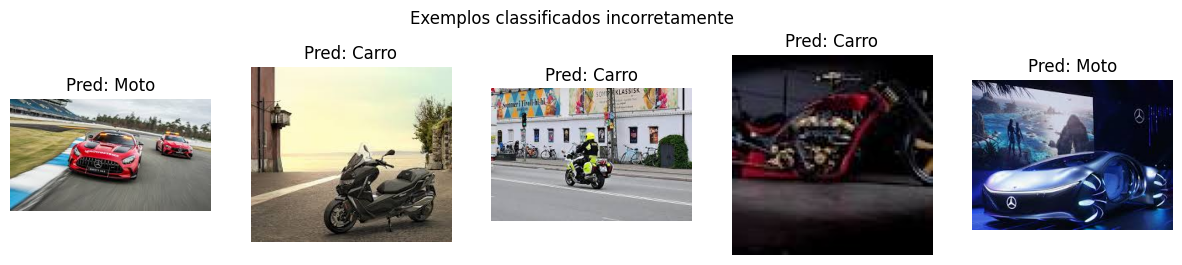

Corretos
      label                            path  pred
441       0   dataset1/Bike/Bike (620).jpeg     0
683       0  dataset1/Bike/Bike (1512).jpeg     0
149       0  dataset1/Bike/Bike (1600).jpeg     0
3760      1    dataset1/Car/Car (1324).jpeg     1
2827      1    dataset1/Car/Car (1892).jpeg     1

Errados
      label                            path  pred
3963      1     dataset1/Car/Car (551).jpeg     0
1885      0  dataset1/Bike/Bike (1272).jpeg     1
1183      0  dataset1/Bike/Bike (1344).jpeg     1
1625      0   dataset1/Bike/Bike (759).jpeg     1
3447      1     dataset1/Car/Car (478).jpeg     0


In [150]:
# Mostrar exemplos de classificação
N_EX = 5
df_test = df_test.copy()
df_test['pred'] = y_pred

df_correct = df_test[df_test['label'] == df_test['pred']]
df_correct = df_correct.sample(min(N_EX, len(df_correct)), random_state=10)
df_wrong = df_test[df_test['label'] != df_test['pred']]
df_wrong = df_wrong.sample(min(N_EX, len(df_wrong)), random_state=42)


show_examples(df_correct, labels, 'Exemplos classificados corretamente')
show_examples(df_wrong, labels, 'Exemplos classificados incorretamente')

print('Corretos')
print(df_correct.loc[:, df_correct.columns != 'features'])
print('\nErrados')
print(df_wrong.loc[:, df_wrong.columns != 'features'])

### Letra b - Classificação com transfer learning
Agora, ao invés do HoG+SVM faremos o processo de transfer learning para treinar um classificador para o dataset. Nesse caso, optei por usar a VGG16 com pesos da imagenet.

Para montar o modelo, foram descartadas as camadas densas do topo da VGG16 e foram adicionadas novas, mais especificamente:
1. Uma camada Flatten para converter o resultados das camadas de convolução para um array de dimensão única.
2. Uma camada Dense com 256 neurônios
3. Uma camada Dense com 128 neurônios
4. Uma camada Dropout com probabilidade 50% para evitar dependência da rede em neurônios específicos.

Na última camada foi usada função de ativação sigmoid, uma vez que o problema é de classificação binária. No mais, foram usadas configurações usuais, como otimizador `adam`, função de perda `binary_crossentropy` (já que se trata de classificação binária) e `accuracy` como métrica.

No preparo dos inputs, foram usadas funções do próprio keras/Tensorflow, que inclue a `ImageDataGenerator` para pre-processar as imagens e empregar Augmentation.

In [128]:
def get_image_dfs(root: Path, labels: list) -> tuple:
    data = []
    for label, folder in enumerate(root.iterdir()):
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            img_path = folder / fname
            data.append({'path': str(img_path), 'label': labels[label]})

    df = pd.DataFrame(data)

    train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


def get_generators(train_df, test_df):
    img_size = (224, 224)
    batch_size = 32

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )

    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
    )

    test_gen = test_datagen.flow_from_dataframe(
        test_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
    )
    return train_gen, test_gen


def get_modified_vgg():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Caminho base do dataset
root = Path('./dataset1')
labels = ['Moto', 'Carro']
train_df, test_df = get_image_dfs(root, labels)
train_gen, test_gen = get_generators(train_df, test_df)

Found 2800 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


In [130]:
model = get_modified_vgg()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_gen, validation_data=test_gen, epochs=6, callbacks=[early_stop])

/home/arthurpmrs/dev/disciplinas/cv/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
 7/88 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.5372 - loss: 1.4067

/home/arthurpmrs/dev/disciplinas/cv/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8243 - loss: 0.5657 - val_accuracy: 0.9733 - val_loss: 0.0664
Epoch 2/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9668 - loss: 0.0893 - val_accuracy: 0.9733 - val_loss: 0.0753
Epoch 3/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9807 - loss: 0.0503 - val_accuracy: 0.9733 - val_loss: 0.0667
Epoch 4/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9788 - loss: 0.0463 - val_accuracy: 0.9767 - val_loss: 0.1060


17/38 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step

/home/arthurpmrs/dev/disciplinas/cv/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step
              precision    recall  f1-score   support

        Moto       0.97      0.97      0.97       600
       Carro       0.97      0.97      0.97       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



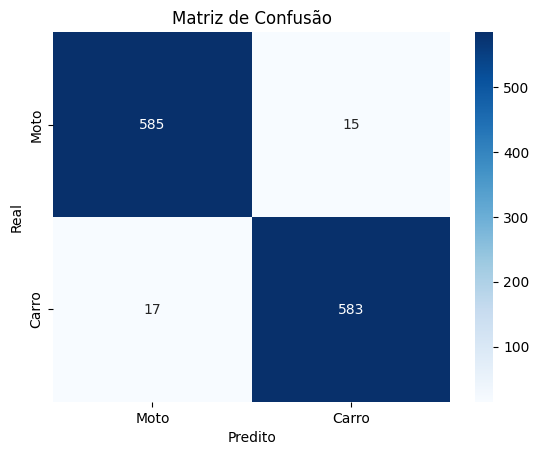

In [146]:
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_test = test_gen.classes

print(classification_report(y_test, y_pred, target_names=labels))
generate_cm(y_test, y_pred, labels)

Como é possível perceber, a CNN obteve um resultado um pouco melhor do que a abordagem HoG+SVM. Esse resultado poderia ser melhor ainda se também fosse empregado o Fine Tunning, ou seja, treinamento de algumas das camadas da própria VGG16.

Abaixo está o código para mostrar exemplos de previsão correta e previsão errada, usando imagens do dataset de test.

obs: Por algum motivo, mesmo a pasta "Bike" estando antes da pasta "Carro", ele usa o label 0 para "Carro" e 1 para "Moto". Por isso tive que ajustar os nomes na hora de printar as imagens.

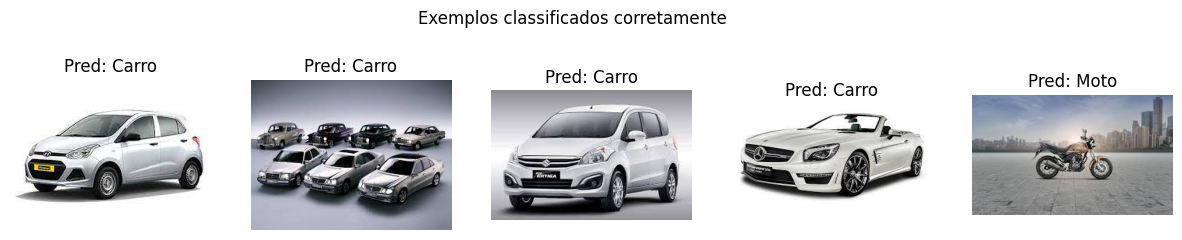

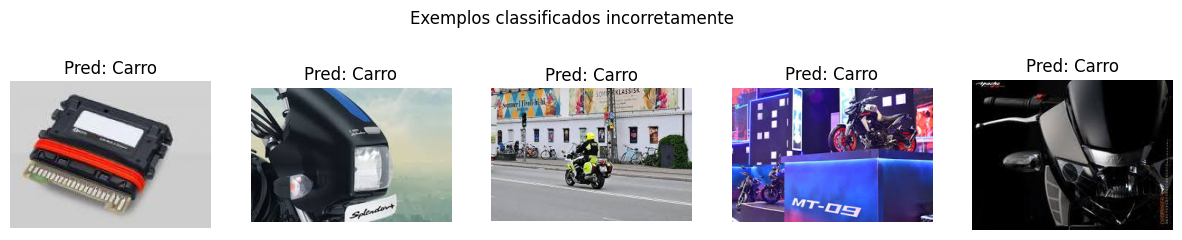

Corretos
                              path  label  pred
621    dataset1/Car/Car (776).jpeg      0     0
70     dataset1/Car/Car (528).jpeg      0     0
44     dataset1/Car/Car (976).jpeg      0     0
985    dataset1/Car/Car (489).jpeg      0     0
786  dataset1/Bike/Bike (582).jpeg      1     1

Errados
                                path  label  pred
845  dataset1/Bike/images (152).jpeg      1     0
456     dataset1/Bike/Bike (42).jpeg      1     0
375   dataset1/Bike/Bike (1344).jpeg      1     0
106    dataset1/Bike/Bike (438).jpeg      1     0
122  dataset1/Bike/images (145).jpeg      1     0


In [ ]:
df_test = pd.DataFrame({'path': test_gen.filepaths, 'label': y_test, 'pred': y_pred})

df_correct = df_test[df_test['label'] == df_test['pred']]
df_correct = df_correct.sample(n=min(5, len(df_correct)), random_state=10)
df_wrong = df_test[df_test['label'] != df_test['pred']]
df_wrong = df_wrong.sample(n=min(5, len(df_wrong)), random_state=10)

show_examples(df_correct, ['Carro', 'Moto'], 'Exemplos classificados corretamente')
show_examples(df_wrong, ['Carro', 'Moto'], 'Exemplos classificados incorretamente')

print('Corretos')
print(df_correct[['path', 'label', 'pred']])
print('\nErrados')
print(df_wrong[['path', 'label', 'pred']])

No caso anterior, ambas as metodologias obtiveram resultados parecidos, 95% para o método HoG+SVM e 97% para o método VGG+Transfer Learning. Acredito que tenha a ver com o dataset e com o fato de que carros e motos têm formatos diferentes, o que levaria a vetores gradiente bem diferentes. 

Achei um outro dataset de laranjas e maças que possui bem menos imagens disponíveis e de tamanho menor. O resultado mostrou uma disparidade maior entre os métodos. Enquanto o método HoG+SVM obteve 56% de acurácia, VGG+Transfer Learning conseguiu chegar a 82%, um resultado consideravelmente melhor.

In [151]:
labels = ['Appels', 'Oragens']
root = Path('./dataset')

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       119
           1       0.57      0.51      0.54       120

    accuracy                           0.56       239
   macro avg       0.56      0.56      0.56       239
weighted avg       0.56      0.56      0.56       239



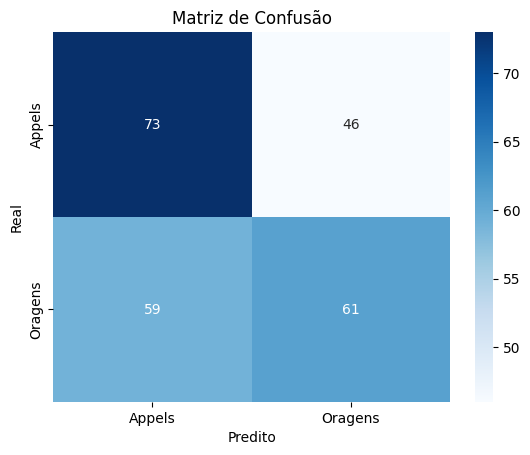

In [152]:
features: pd.DataFrame = extract_features(hog, root)
y_pred, df_test = train_svm(features)

result = classification_report(df_test['label'], y_pred)
print(result)

generate_cm(df_test['label'], y_pred, labels)

In [153]:
train_df, test_df = get_image_dfs(root, labels)
train_gen, test_gen = get_generators(train_df, test_df)

Found 557 validated image filenames belonging to 2 classes.
Found 239 validated image filenames belonging to 2 classes.


In [154]:
model = get_modified_vgg()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_gen, validation_data=test_gen, epochs=8, callbacks=[early_stop])

/home/arthurpmrs/dev/disciplinas/cv/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4618 - loss: 1.6445 - val_accuracy: 0.7406 - val_loss: 0.6027
Epoch 2/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6237 - loss: 0.8486 - val_accuracy: 0.7992 - val_loss: 0.4829
Epoch 3/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7842 - loss: 0.4857 - val_accuracy: 0.7741 - val_loss: 0.4537
Epoch 4/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8308 - loss: 0.3777 - val_accuracy: 0.7950 - val_loss: 0.5020
Epoch 5/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8440 - loss: 0.4271 - val_accuracy: 0.7699 - val_loss: 0.4622
Epoch 6/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9122 - loss: 0.2401 - val_accuracy: 0.8201 - val_loss: 0.4242
Epoch 7/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9153 - loss: 0.2266 - val_accuracy: 0.8117 - val_loss: 0.4714
Epoch 8/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9323 - loss: 0.1874 - val_accuracy: 0.8075 - val_loss: 0.5157


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
              precision    recall  f1-score   support

      Appels       0.84      0.79      0.81       119
     Oragens       0.80      0.85      0.83       120

    accuracy                           0.82       239
   macro avg       0.82      0.82      0.82       239
weighted avg       0.82      0.82      0.82       239



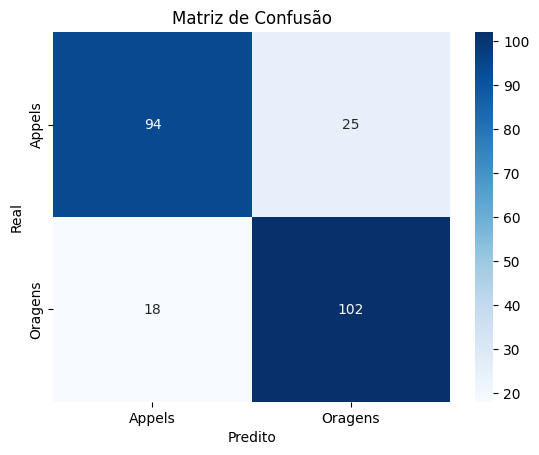

In [155]:
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_test = test_gen.classes

print(classification_report(y_test, y_pred, target_names=labels))
generate_cm(y_test, y_pred, labels)